# Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import string
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, plot_confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from imblearn.combine import SMOTETomek
from sklearn.ensemble import BaggingClassifier
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC

# Loading dataset

In [2]:
airline = pd.read_csv('Tweets.csv')

In [3]:
airline[airline['retweet_count']>0]

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
136,569625739231948800,positive,1.0,NaN,NaN,Virgin America,NaN,lisaptv,NaN,1,@virginamerica you ROCK for making it so I can...,NaN,2015-02-22 14:32:14 -0800,NaN,Mountain Time (US & Canada)
147,569599867716132864,positive,1.0,NaN,NaN,Virgin America,NaN,jessicajaymes,NaN,2,Always have it together!!! You're welcome! RT ...,"[33.94652852, -118.40766257]",2015-02-22 12:49:25 -0800,"hollywood, california",Pacific Time (US & Canada)
264,568929979981033472,positive,1.0,NaN,NaN,Virgin America,NaN,djchuang,NaN,1,@VirginAmerica thanks for gate checking my bag...,"[32.8454782, -96.8504585]",2015-02-20 16:27:32 -0800,"Orange County, CA",Pacific Time (US & Canada)
304,568812046747201537,negative,1.0,Lost Luggage,1.0000,Virgin America,NaN,snellbell,NaN,1,@VirginAmerica lost my luggage 4 days ago on f...,NaN,2015-02-20 08:38:54 -0800,NaN,Quito
318,568735060104511488,neutral,1.0,NaN,NaN,Virgin America,NaN,gemmabow19,NaN,2,@VirginAmerica can u help this 👸 @FreyaBevan_F...,NaN,2015-02-20 03:32:59 -0800,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14426,569617808885096448,negative,1.0,Customer Service Issue,1.0000,American,NaN,ejacqui,NaN,1,"@AmericanAir no one received text alerts, auto...",NaN,2015-02-22 14:00:43 -0800,Chicago,Central Time (US & Canada)
14524,569604328153083904,negative,1.0,Late Flight,0.6849,American,NaN,farazq,NaN,1,@AmericanAir can you do anything to get #AA953...,"[40.80718573, -73.95477259]",2015-02-22 13:07:09 -0800,"New York, NY",Quito
14532,569603156927246336,negative,1.0,Flight Booking Problems,0.6964,American,NaN,JasonShaw2,NaN,2,@AmericanAir missing a full days of work thank...,NaN,2015-02-22 13:02:29 -0800,Belleville,Eastern Time (US & Canada)
14547,569601094239825920,positive,1.0,NaN,NaN,American,NaN,EricRoberts,NaN,1,Eliza &amp; I cheated on u @AmericanAir with @...,NaN,2015-02-22 12:54:18 -0800,"Los Angeles, CA",Pacific Time (US & Canada)


# 14640 rows and 15 columns

In [4]:
airline.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [5]:
airline.isnull().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

# Deleting unnecessary columns

In [6]:
airline.drop(['negativereason','negativereason_confidence','airline_sentiment_gold','negativereason_gold','tweet_coord','tweet_location','user_timezone'],axis=1,inplace=True)

In [7]:
airline

,tweet_id,airline_sentiment,airline_sentiment_confidence,airline,name,retweet_count,text,tweet_created
0,570306133677760513,neutral,1.0000,Virgin America,cairdin,0,@VirginAmerica What @dhepburn said.,2015-02-24 11:35:52 -0800
1,570301130888122368,positive,0.3486,Virgin America,jnardino,0,@VirginAmerica plus you've added commercials t...,2015-02-24 11:15:59 -0800
2,570301083672813571,neutral,0.6837,Virgin America,yvonnalynn,0,@VirginAmerica I didn't today... Must mean I n...,2015-02-24 11:15:48 -0800
3,570301031407624196,negative,1.0000,Virgin America,jnardino,0,@VirginAmerica it's really aggressive to blast...,2015-02-24 11:15:36 -0800
4,570300817074462722,negative,1.0000,Virgin America,jnardino,0,@VirginAmerica and it's a really big bad thing...,2015-02-24 11:14:45 -0800
...,...,...,...,...,...,...,...,...
14635,569587686496825344,positive,0.3487,American,KristenReenders,0,@AmericanAir thank you we got on a different f...,2015-02-22 12:01:01 -0800
14636,569587371693355008,negative,1.0000,American,itsropes,0,@AmericanAir leaving over 20 minutes Late Flig...,2015-02-22 11:59:46 -0800
14637,569587242672398336,neutral,1.0000,American,sanyabun,0,@AmericanAir Please bring American Airlines to...,2015-02-22 11:59:15 -0800
14638,569587188687634433,negative,1.0000,American,SraJackson,0,"@AmericanAir you have my money, you change my ...",2015-02-22 11:59:02 -0800


In [8]:
airline.drop(['tweet_id','name','tweet_created'],axis=1,inplace=True)

In [9]:
airline[airline['text'].str.contains('👸')]

,airline_sentiment,airline_sentiment_confidence,airline,retweet_count,text
318,neutral,1.0000,Virgin America,2,@VirginAmerica can u help this 👸 @FreyaBevan_F...
7892,neutral,0.6526,Delta,0,@JetBlue Get me out of this 7 degree weather.....


# Different airlines

In [10]:
airline['airline'].value_counts()

United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: airline, dtype: int64

<AxesSubplot:xlabel='airline', ylabel='count'>

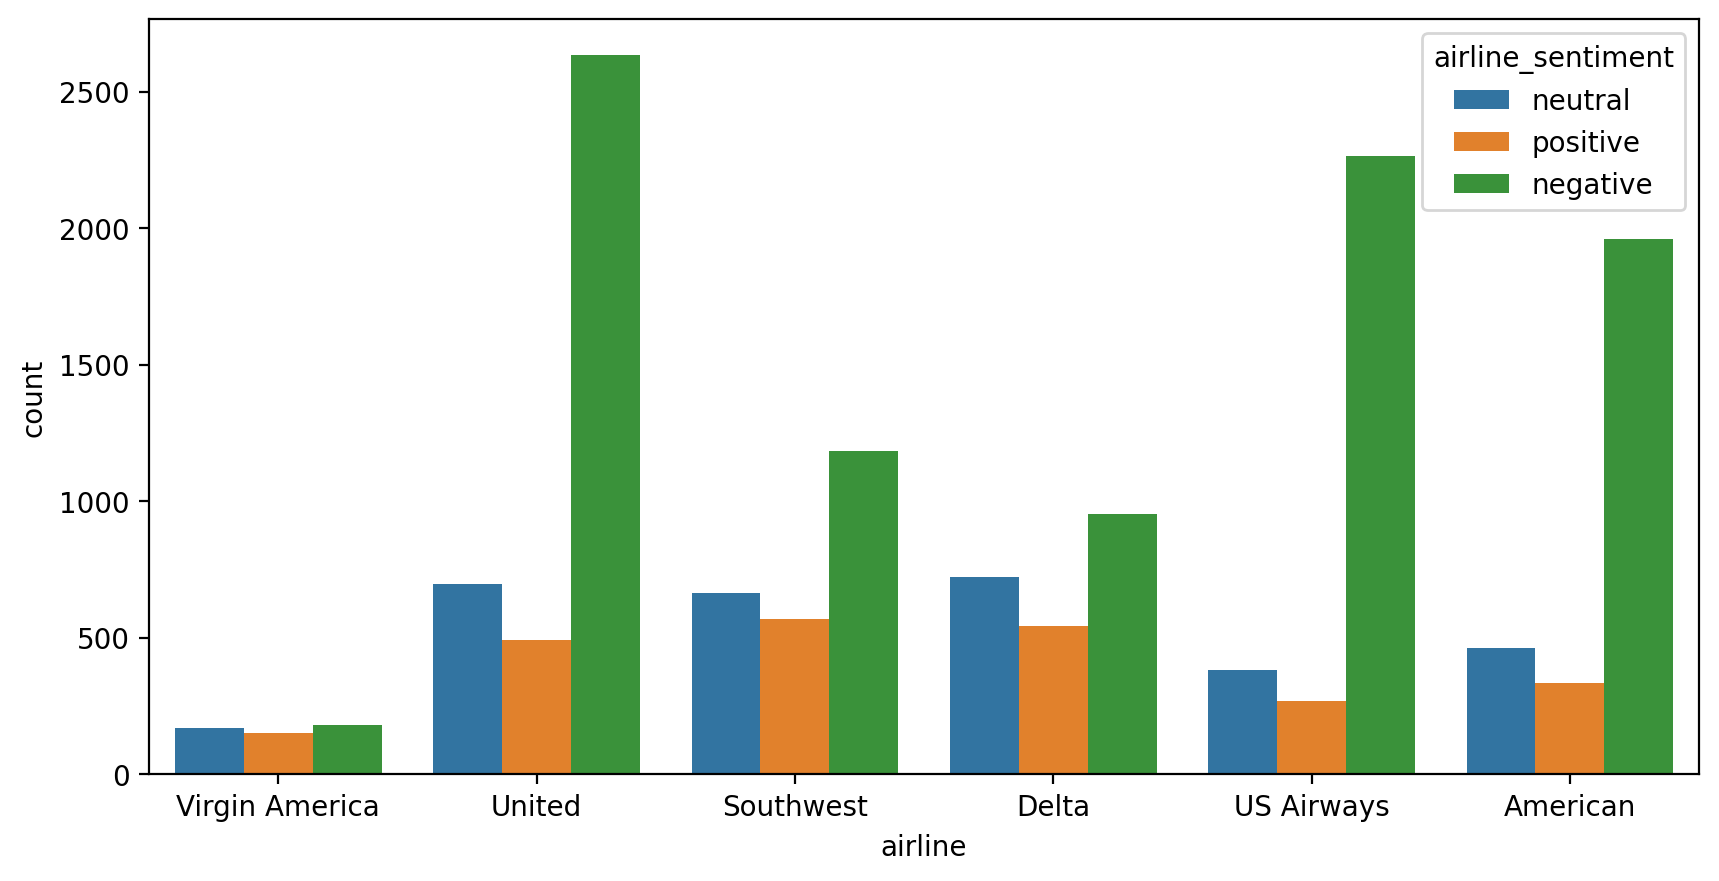

In [11]:
plt.figure(figsize=(10,5),dpi=200)
sns.countplot(x='airline',data=airline, hue='airline_sentiment')

# Data preprocessing

In [12]:
airline

,airline_sentiment,airline_sentiment_confidence,airline,retweet_count,text
0,neutral,1.0000,Virgin America,0,@VirginAmerica What @dhepburn said.
1,positive,0.3486,Virgin America,0,@VirginAmerica plus you've added commercials t...
2,neutral,0.6837,Virgin America,0,@VirginAmerica I didn't today... Must mean I n...
3,negative,1.0000,Virgin America,0,@VirginAmerica it's really aggressive to blast...
4,negative,1.0000,Virgin America,0,@VirginAmerica and it's a really big bad thing...
...,...,...,...,...,...
14635,positive,0.3487,American,0,@AmericanAir thank you we got on a different f...
14636,negative,1.0000,American,0,@AmericanAir leaving over 20 minutes Late Flig...
14637,neutral,1.0000,American,0,@AmericanAir Please bring American Airlines to...
14638,negative,1.0000,American,0,"@AmericanAir you have my money, you change my ..."


In [13]:
stop = stopwords.words('english')

In [14]:
extra = ['@','VirginAmerica','united','SouthwestAir','JetBlue','USAirways','AmericanAir']

In [15]:
stop.extend(extra)

In [16]:
stop.extend(string.punctuation)

In [17]:
stop.extend(string.digits)

In [18]:
stop

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [19]:
lemmatizer = WordNetLemmatizer()

In [20]:
stemmer = PorterStemmer()

In [21]:
def prep(i):
    i = i.lower()
    words = nltk.word_tokenize(i)
    words=[stemmer.stem(word) for word in words if word not in stop and (len(word)>=3) and (len(word)<=20)]
    return ' '.join(words)

In [22]:
airline['text'] = airline.text.apply(prep)

In [23]:
airline['text'][7892]

'jetblu get degre weather ... westpalmbeachbound 🌞✈️👸'

# Separating different airlines in different dataset 

In [24]:
virgin_america = airline[airline['airline'] == 'Virgin America']

In [25]:
virgin_america.drop(['airline'],axis=1,inplace=True)
virgin_america

C:\Users\Dell\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,airline_sentiment,airline_sentiment_confidence,retweet_count,text
0,neutral,1.0000,0,virginamerica dhepburn said
1,positive,0.3486,0,virginamerica plu 've ad commerci experi ... t...
2,neutral,0.6837,0,virginamerica n't today ... must mean need tak...
3,negative,1.0000,0,virginamerica realli aggress blast obnoxi ente...
4,negative,1.0000,0,virginamerica realli big bad thing
...,...,...,...,...
499,neutral,1.0000,0,virginamerica morn question regard elev point ...
500,neutral,0.6694,0,virginamerica still wait see starryeyes_dev_
501,neutral,0.6376,0,virginamerica wonder guy reciev 're abl potent...
502,positive,1.0000,4,virginamerica fli lax sfo look awesom movi lin...


In [26]:
united = airline[airline['airline'] == 'United']

In [27]:
united.drop(['airline'],axis=1,inplace=True)
united

C:\Users\Dell\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,airline_sentiment,airline_sentiment_confidence,retweet_count,text
504,positive,1.0000,0,thank
505,positive,1.0000,0,thank take care happi custom
506,negative,1.0000,0,still refund word via pleas resolv issu cancel...
507,negative,1.0000,0,delay due lack crew delay long line deic ... s...
508,positive,0.3441,0,thank fill luck common
...,...,...,...,...
4321,negative,1.0000,0,link current statu flights/airport fli bwi-ewr...
4322,negative,1.0000,0,like delay less one plane connect voucher
4323,negative,1.0000,0,n't hope nicer flight time tri thing right sol...
4324,negative,1.0000,0,got gate iah time given seat close flight know...


In [28]:
southwest = airline[airline['airline'] == 'Southwest']

In [29]:
southwest.drop(['airline'],axis=1,inplace=True)
southwest

C:\Users\Dell\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,airline_sentiment,airline_sentiment_confidence,retweet_count,text
4326,negative,1.0000,0,southwestair still wait hit one hour
4327,negative,0.6361,0,southwestair although happi cancel flight flig...
4328,negative,1.0000,0,southwestair hello hold extrem long time confi...
4329,neutral,0.6443,0,southwestair teach new travel research budget ...
4330,negative,1.0000,0,southwestair frustrat loooooong wait time spea...
...,...,...,...,...
6741,negative,1.0000,0,southwestair n't answer phone horribleservic n...
6742,negative,1.0000,0,southwestair stuck sju sever hour one answer r...
6743,positive,1.0000,0,southwestair nice work updat
6744,negative,1.0000,0,southwestair guy hour phone hold 3am volum sho...


In [30]:
delta = airline[airline['airline'] == 'Delta']

In [31]:
delta.drop(['airline'],axis=1,inplace=True)
delta

C:\Users\Dell\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,airline_sentiment,airline_sentiment_confidence,retweet_count,text
6746,positive,0.6469,0,jetblu yesterday way ewr fll take-off wheelsup...
6747,neutral,0.6869,0,jetblu hope fli often would hate chang airlin
6748,neutral,1.0000,0,jetblu flight 1041 savannah
6749,negative,1.0000,0,jetblu n't flight came late flight jetblu empl...
6750,negative,1.0000,0,jetblu everyon pilot found last flight plane d...
...,...,...,...,...
8963,neutral,1.0000,0,jetblu ceo weigh profit flyer chronicleherald ...
8964,negative,1.0000,0,jetblu realli get nerv nothappi
8965,neutral,1.0000,0,jetblu new ceo seek right balanc pleas passeng...
12038,negative,1.0000,0,deltaassist minut wait silver elit line someon...


In [32]:
us_airways = airline[airline['airline'] == 'US Airways']

In [33]:
us_airways.drop(['airline'],axis=1,inplace=True)
us_airways

C:\Users\Dell\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,airline_sentiment,airline_sentiment_confidence,retweet_count,text
8966,negative,0.6292,0,usairway better time call flight friday need c...
8967,negative,1.0000,0,usairway one agent avail speak
8968,neutral,1.0000,0,usairway possibl n't follow
8969,neutral,1.0000,0,usairway fortun staff like lynn deede actual u...
8970,negative,1.0000,0,usairway hung anoth wast hour time suppos book...
...,...,...,...,...
11874,negative,1.0000,0,usairway hold gold reserv line hour flight can...
11875,negative,1.0000,0,usairway choic pay anoth airport hope treat be...
11876,negative,1.0000,0,usairway reserv hold hour hang ... smh
11877,negative,1.0000,0,usairway americanair suppos chang flight n't g...


In [34]:
american = airline[airline['airline'] == 'American']

In [35]:
american.drop(['airline'],axis=1,inplace=True)
american

C:\Users\Dell\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,airline_sentiment,airline_sentiment_confidence,retweet_count,text
11879,negative,1.0000,0,americanair would even consid continu point pr...
11880,neutral,0.6667,0,americanair 've alreadi made arrang
11881,negative,0.6316,0,americanair thank get back find airlin futur
11882,negative,0.6846,0,americanair would pay 200 reactiv point use ce...
11883,negative,0.6547,0,americanair strand hour mia patrick casimir st...
...,...,...,...,...
14635,positive,0.3487,0,americanair thank got differ flight chicago
14636,negative,1.0000,0,americanair leav minut late flight warn commun...
14637,neutral,1.0000,0,americanair pleas bring american airlin blackb...
14638,negative,1.0000,0,americanair money chang flight n't answer phon...


# Unbalanced data

## Virgin America

### Tfidf vectorization & splitting into train test

In [36]:
tf=TfidfVectorizer()

In [37]:
xva = virgin_america['text']

In [38]:
yva = virgin_america['airline_sentiment']

In [39]:
xva = tf.fit_transform(xva)

In [40]:
xva

<504x1482 sparse matrix of type '<class 'numpy.float64'>'
	with 4599 stored elements in Compressed Sparse Row format>

In [41]:
xva_train, xva_test, yva_train, yva_test = train_test_split(xva, yva, test_size=0.34, random_state=101)

In [209]:
xva_train

<332x1482 sparse matrix of type '<class 'numpy.float64'>'
	with 3036 stored elements in Compressed Sparse Row format>

In [42]:
'''param_grid = { 
    'n_estimators': [200,250,260,270,300,350,100, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}
'''

"param_grid = { \n    'n_estimators': [200,250,260,270,300,350,100, 500],\n    'max_features': ['auto', 'sqrt', 'log2'],\n    'max_depth' : [4,5,6,7,8],\n    'criterion' :['gini', 'entropy']\n}\n"

In [43]:
xva

<504x1482 sparse matrix of type '<class 'numpy.float64'>'
	with 4599 stored elements in Compressed Sparse Row format>

### ID3 our - 63.95% paper - 32.74%

In [44]:
id3 = RandomForestClassifier(n_estimators=250, criterion='entropy')

In [45]:
#CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
#CV_rfc.fit(xva_train, yva_train)

In [46]:
id3.fit(xva_train, yva_train)

RandomForestClassifier(criterion='entropy', n_estimators=250)

In [47]:
id3_preds = id3.predict(xva_test)

0.6104651162790697
              precision    recall  f1-score   support

    negative       0.68      0.74      0.71        61
     neutral       0.54      0.61      0.57        59
    positive       0.62      0.46      0.53        52

    accuracy                           0.61       172
   macro avg       0.61      0.60      0.60       172
weighted avg       0.61      0.61      0.61       172



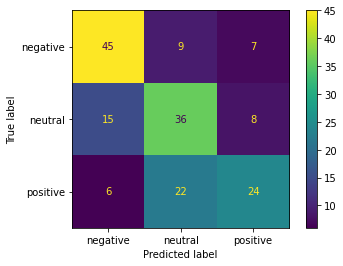

In [48]:
id3_score = accuracy_score(yva_test, id3_preds)
print(id3_score)
id3_matrix = plot_confusion_matrix(id3, xva_test, yva_test)
print(id3_matrix)
id3_report = classification_report(yva_test, id3_preds)
print(id3_report)

### Random Forest Classifier our - 62.20% paper - 31.86%

In [49]:
rfc = RandomForestClassifier(n_estimators=250, criterion='gini')

In [50]:
rfc.fit(xva_train, yva_train)

RandomForestClassifier(n_estimators=250)

In [51]:
rfc_preds = rfc.predict(xva_test)

0.622093023255814
              precision    recall  f1-score   support

    negative       0.67      0.77      0.72        61
     neutral       0.53      0.61      0.57        59
    positive       0.71      0.46      0.56        52

    accuracy                           0.62       172
   macro avg       0.64      0.61      0.61       172
weighted avg       0.63      0.62      0.62       172



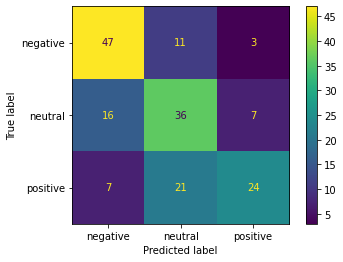

In [52]:
rfc_score = accuracy_score(yva_test, rfc_preds)
print(rfc_score)
rfc_matrix = plot_confusion_matrix(rfc, xva_test, yva_test)
print(rfc_matrix)
rfc_report = classification_report(yva_test, rfc_preds)
print(rfc_report)

### Naive Bayes our - 56.97% paper - 32.74%

In [53]:
nbva = MultinomialNB()

In [54]:
nbva.fit(xva_train, yva_train)

MultinomialNB()

In [55]:
nbva_preds = nbva.predict(xva_test)

0.5697674418604651
              precision    recall  f1-score   support

    negative       0.54      0.82      0.65        61
     neutral       0.50      0.39      0.44        59
    positive       0.76      0.48      0.59        52

    accuracy                           0.57       172
   macro avg       0.60      0.56      0.56       172
weighted avg       0.59      0.57      0.56       172



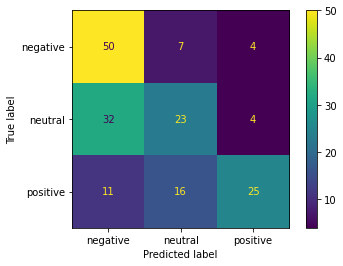

In [56]:
nbva_score = accuracy_score(yva_test, nbva_preds)
print(nbva_score)
nbva_matrix = plot_confusion_matrix(nbva, xva_test, yva_test)
print(nbva_matrix)
nbva_report = classification_report(yva_test, nbva_preds)
print(nbva_report)

### Decision Tree our - 51.74% paper - 31.86%

In [57]:
dtva = DecisionTreeClassifier()

In [58]:
dtva.fit(xva_train, yva_train)

DecisionTreeClassifier()

In [59]:
dtva_preds = dtva.predict(xva_test)

0.5232558139534884
              precision    recall  f1-score   support

    negative       0.60      0.48      0.53        61
     neutral       0.44      0.64      0.52        59
    positive       0.62      0.44      0.52        52

    accuracy                           0.52       172
   macro avg       0.55      0.52      0.52       172
weighted avg       0.55      0.52      0.52       172



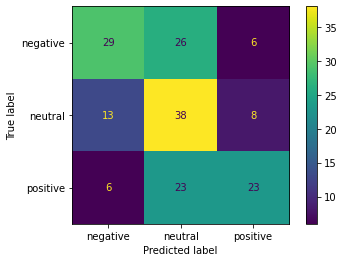

In [60]:
dtva_score = accuracy_score(yva_test, dtva_preds)
print(dtva_score)
dtva_matrix = plot_confusion_matrix(dtva, xva_test, yva_test)
print(dtva_matrix)
dtva_report = classification_report(yva_test, dtva_preds)
print(dtva_report)

### KNN Classifier our - 56.97% paper - 39.82%

In [61]:
knnva = KNeighborsClassifier(n_neighbors=5, leaf_size=5, p=2)

In [62]:
knnva.fit(xva_train, yva_train)

KNeighborsClassifier(leaf_size=5)

In [63]:
knnva_preds = knnva.predict(xva_test)

0.5697674418604651
              precision    recall  f1-score   support

    negative       0.56      0.67      0.61        61
     neutral       0.49      0.47      0.48        59
    positive       0.69      0.56      0.62        52

    accuracy                           0.57       172
   macro avg       0.58      0.57      0.57       172
weighted avg       0.58      0.57      0.57       172



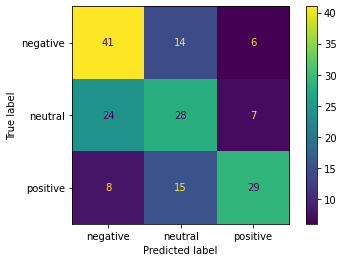

In [64]:
knnva_score = accuracy_score(yva_test, knnva_preds)
print(knnva_score)
knnva_matrix = plot_confusion_matrix(knnva, xva_test, yva_test)
print(knnva_matrix)
knnva_report = classification_report(yva_test, knnva_preds)
print(knnva_report)

### SVC

In [65]:
svcva = SVC(kernel ='poly', degree=2, gamma = 'scale', shrinking = True)

In [66]:
svcva.fit(xva_train, yva_train)

SVC(degree=2, kernel='poly')

In [67]:
svcva_preds = svcva.predict(xva_test)

0.5465116279069767
              precision    recall  f1-score   support

    negative       0.51      0.85      0.64        61
     neutral       0.47      0.41      0.44        59
    positive       0.90      0.35      0.50        52

    accuracy                           0.55       172
   macro avg       0.63      0.54      0.53       172
weighted avg       0.62      0.55      0.53       172



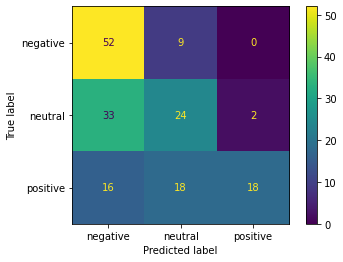

In [68]:
svcva_score = accuracy_score(yva_test, svcva_preds)
print(svcva_score)
svcva_matrix = plot_confusion_matrix(svcva, xva_test, yva_test)
print(svcva_matrix)
svcva_report = classification_report(yva_test, svcva_preds)
print(svcva_report)

# United

### Tfidf vectorization & splitting into train test

In [69]:
xu = united['text']

In [70]:
yu = united['airline_sentiment']

In [71]:
xu = tf.fit_transform(xu)

In [72]:
xu_train, xu_test, yu_train, yu_test = train_test_split(xu, yu, test_size=0.34, random_state=101)

### ID3 our - 75.23% paper - 72.38%

In [73]:
id3u = RandomForestClassifier(n_estimators=250, criterion='entropy')

In [74]:
id3u.fit(xu_train, yu_train)

RandomForestClassifier(criterion='entropy', n_estimators=250)

In [75]:
id3u_preds = id3u.predict(xu_test)

0.7523076923076923
              precision    recall  f1-score   support

    negative       0.76      0.97      0.85       902
     neutral       0.59      0.13      0.21       221
    positive       0.75      0.41      0.53       177

    accuracy                           0.75      1300
   macro avg       0.70      0.50      0.53      1300
weighted avg       0.73      0.75      0.70      1300



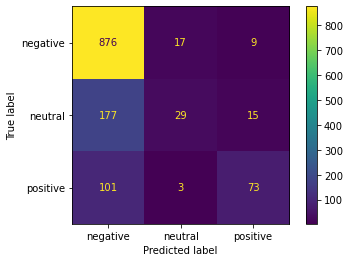

In [76]:
id3u_score = accuracy_score(yu_test, id3u_preds)
print(id3u_score)
id3u_matrix = plot_confusion_matrix(id3u, xu_test, yu_test)
print(id3u_matrix)
id3u_report = classification_report(yu_test, id3u_preds)
print(id3u_report)

### Random Forest Classifier our - 74.84% paper - 72.03%

In [77]:
rfcu = RandomForestClassifier(n_estimators=250, criterion='gini')

In [78]:
rfcu.fit(xu_train, yu_train)

RandomForestClassifier(n_estimators=250)

In [79]:
rfcu_preds = rfcu.predict(xu_test)

0.7530769230769231
              precision    recall  f1-score   support

    negative       0.76      0.97      0.85       902
     neutral       0.61      0.14      0.22       221
    positive       0.75      0.41      0.53       177

    accuracy                           0.75      1300
   macro avg       0.71      0.51      0.54      1300
weighted avg       0.73      0.75      0.70      1300



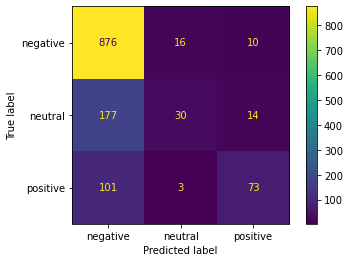

In [80]:
rfcu_score = accuracy_score(yu_test, rfcu_preds)
print(rfcu_score)
rfcu_matrix = plot_confusion_matrix(rfcu, xu_test, yu_test)
print(rfcu_matrix)
rfcu_report = classification_report(yu_test, rfcu_preds)
print(rfcu_report)

### Naive Bayes our - 70.38% paper- 72.38%

In [81]:
nbu = MultinomialNB()

In [82]:
nbu.fit(xu_train, yu_train)

MultinomialNB()

In [83]:
nbu_preds = nbu.predict(xu_test)

0.7038461538461539
              precision    recall  f1-score   support

    negative       0.70      1.00      0.83       902
     neutral       1.00      0.01      0.02       221
    positive       0.73      0.06      0.11       177

    accuracy                           0.70      1300
   macro avg       0.81      0.36      0.32      1300
weighted avg       0.76      0.70      0.59      1300



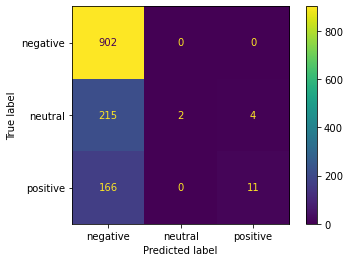

In [84]:
nbu_score = accuracy_score(yu_test, nbu_preds)
print(nbu_score)
nbu_matrix = plot_confusion_matrix(nbu, xu_test, yu_test)
print(nbu_matrix)
nbu_report = classification_report(yu_test, nbu_preds)
print(nbu_report)

### Decision Tree our - 72.15% paper - 72.03%

In [85]:
dtu = DecisionTreeClassifier(max_depth=7)

In [86]:
dtu.fit(xu_train, yu_train)

DecisionTreeClassifier(max_depth=7)

In [87]:
dtu_preds = dtu.predict(xu_test)

0.7223076923076923
              precision    recall  f1-score   support

    negative       0.75      0.95      0.84       902
     neutral       0.21      0.02      0.03       221
    positive       0.57      0.45      0.50       177

    accuracy                           0.72      1300
   macro avg       0.51      0.47      0.46      1300
weighted avg       0.63      0.72      0.65      1300



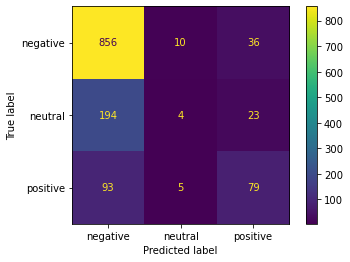

In [88]:
dtu_score = accuracy_score(yu_test, dtu_preds)
print(dtu_score)
dtu_matrix = plot_confusion_matrix(dtu, xu_test, yu_test)
print(dtu_matrix)
dtu_report = classification_report(yu_test, dtu_preds)
print(dtu_report)

### KNN Classifier our- 71.30% paper - 11.66%

In [89]:
knnu = KNeighborsClassifier(n_neighbors=5, leaf_size=5, p=2)

In [90]:
knnu.fit(xu_train, yu_train)

KNeighborsClassifier(leaf_size=5)

In [91]:
knnu_preds = knnu.predict(xu_test)

0.713076923076923
              precision    recall  f1-score   support

    negative       0.71      0.99      0.83       902
     neutral       0.58      0.05      0.09       221
    positive       0.77      0.11      0.20       177

    accuracy                           0.71      1300
   macro avg       0.69      0.39      0.37      1300
weighted avg       0.70      0.71      0.62      1300



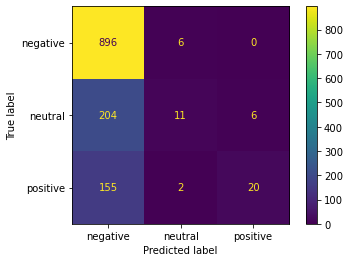

In [92]:
knnu_score = accuracy_score(yu_test, knnu_preds)
print(knnu_score)
knnu_matrix = plot_confusion_matrix(knnu, xu_test, yu_test)
print(knnu_matrix)
knnu_report = classification_report(yu_test, knnu_preds)
print(knnu_report)

### SVC

In [93]:
svcu = SVC(kernel ='poly', degree=2, gamma = 'scale', shrinking = True)

In [94]:
svcu.fit(xu_train, yu_train)

SVC(degree=2, kernel='poly')

In [95]:
svcu_preds = svcu.predict(xu_test)

0.7315384615384616
              precision    recall  f1-score   support

    negative       0.73      1.00      0.84       902
     neutral       0.76      0.06      0.11       221
    positive       0.82      0.23      0.35       177

    accuracy                           0.73      1300
   macro avg       0.77      0.43      0.43      1300
weighted avg       0.75      0.73      0.65      1300



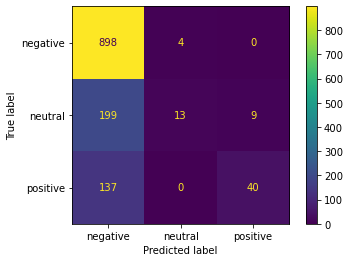

In [96]:
svcu_score = accuracy_score(yu_test, svcu_preds)
print(svcu_score)
svcu_matrix = plot_confusion_matrix(svcu, xu_test, yu_test)
print(svcu_matrix)
svcu_report = classification_report(yu_test, svcu_preds)
print(svcu_report)

# Southwest

### Tfidf vectorization & splitting into train test

In [97]:
xs = southwest['text']

In [98]:
ys = southwest['airline_sentiment']

In [99]:
xs = tf.fit_transform(xs)

In [100]:
xs_train, xs_test, ys_train, ys_test = train_test_split(xs, ys, test_size=0.34, random_state=101)

### ID3 our - 68.52% paper - 51.01%

In [101]:
id3s = RandomForestClassifier(n_estimators=250, criterion='gini')

In [102]:
id3s.fit(xs_train, ys_train)

RandomForestClassifier(n_estimators=250)

In [103]:
id3s_preds = id3s.predict(xs_test)

0.6828675577156743
              precision    recall  f1-score   support

    negative       0.68      0.88      0.76       389
     neutral       0.63      0.43      0.51       242
    positive       0.75      0.61      0.67       192

    accuracy                           0.68       823
   macro avg       0.69      0.64      0.65       823
weighted avg       0.68      0.68      0.67       823



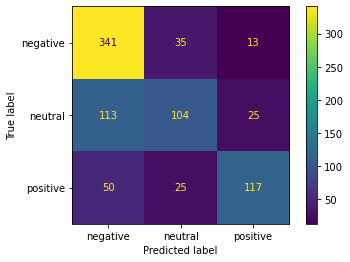

In [104]:
id3s_score = accuracy_score(ys_test, id3s_preds)
print(id3s_score)
id3s_matrix = plot_confusion_matrix(id3s, xs_test, ys_test)
print(id3s_matrix)
id3s_report = classification_report(ys_test, id3s_preds)
print(id3s_report)

### Random Forest Classifier our - 68.04% paper - 50.46%

In [105]:
rfcs = RandomForestClassifier(n_estimators=250, criterion='entropy')

In [106]:
rfcs.fit(xs_train, ys_train)

RandomForestClassifier(criterion='entropy', n_estimators=250)

In [107]:
rfcs_preds = rfcs.predict(xs_test)

0.6913730255164034
              precision    recall  f1-score   support

    negative       0.68      0.89      0.77       389
     neutral       0.65      0.44      0.52       242
    positive       0.75      0.61      0.68       192

    accuracy                           0.69       823
   macro avg       0.70      0.65      0.66       823
weighted avg       0.69      0.69      0.68       823



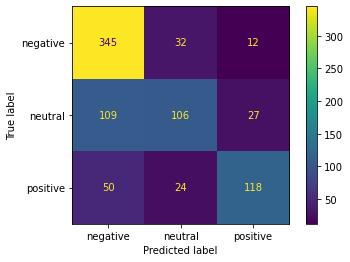

In [108]:
rfcs_score = accuracy_score(ys_test, rfcs_preds)
print(rfcs_score)
rfcs_matrix = plot_confusion_matrix(rfcs, xs_test, ys_test)
print(rfcs_matrix)
rfcs_report = classification_report(ys_test, rfcs_preds)
print(rfcs_report)

### Naive Bayes our - 60.63% paper - 51.01%

In [109]:
nbs = MultinomialNB()

In [110]:
nbs.fit(xs_train, ys_train)

MultinomialNB()

In [111]:
nbs_preds = nbs.predict(xs_test)

0.606318347509113
              precision    recall  f1-score   support

    negative       0.56      0.99      0.72       389
     neutral       0.78      0.19      0.31       242
    positive       0.87      0.35      0.50       192

    accuracy                           0.61       823
   macro avg       0.74      0.51      0.51       823
weighted avg       0.70      0.61      0.55       823



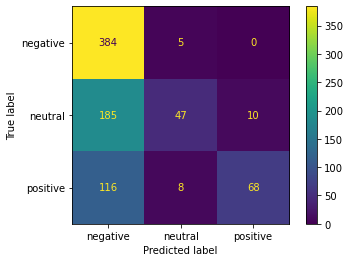

In [112]:
nbs_score = accuracy_score(ys_test, nbs_preds)
print(nbs_score)
nbs_matrix = plot_confusion_matrix(nbs, xs_test, ys_test)
print(nbs_matrix)
nbs_report = classification_report(ys_test, nbs_preds)
print(nbs_report)

### Decision Tree our - 62.45% paper - 50.46%

In [113]:
dts = DecisionTreeClassifier()

In [114]:
dts.fit(xs_train, ys_train)

DecisionTreeClassifier()

In [115]:
dts_preds = dts.predict(xs_test)

0.606318347509113
              precision    recall  f1-score   support

    negative       0.68      0.73      0.70       389
     neutral       0.50      0.47      0.49       242
    positive       0.57      0.53      0.55       192

    accuracy                           0.61       823
   macro avg       0.58      0.58      0.58       823
weighted avg       0.60      0.61      0.60       823



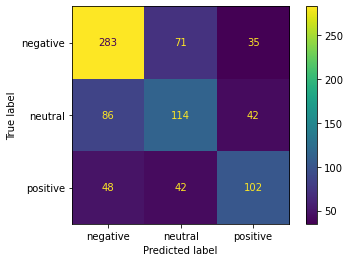

In [116]:
dts_score = accuracy_score(ys_test, dts_preds)
print(dts_score)
dts_matrix = plot_confusion_matrix(dts, xs_test, ys_test)
print(dts_matrix)
dts_report = classification_report(ys_test, dts_preds)
print(dts_report)

### KNN Classifier our - 64.52 paper- 50.46%

In [117]:
knns = KNeighborsClassifier(n_neighbors=5, leaf_size=5, p=2)

In [118]:
knns.fit(xs_train, ys_train)

KNeighborsClassifier(leaf_size=5)

In [119]:
knns_preds = knns.predict(xs_test)

0.6452004860267315
              precision    recall  f1-score   support

    negative       0.69      0.80      0.74       389
     neutral       0.52      0.45      0.48       242
    positive       0.67      0.57      0.62       192

    accuracy                           0.65       823
   macro avg       0.63      0.61      0.62       823
weighted avg       0.64      0.65      0.64       823



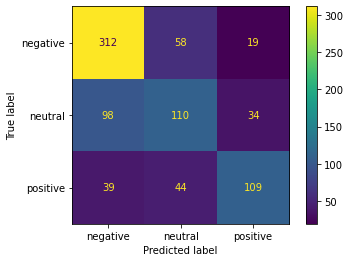

In [120]:
knns_score = accuracy_score(ys_test, knns_preds)
print(knns_score)
knns_matrix = plot_confusion_matrix(knns, xs_test, ys_test)
print(knns_matrix)
knns_report = classification_report(ys_test, knns_preds)
print(knns_report)

### SVC

In [121]:
svcs = SVC(kernel ='poly',degree=2,gamma = 'scale', shrinking = True)

In [122]:
svcs.fit(xs_train, ys_train)

SVC(degree=2, kernel='poly')

In [123]:
svcs_preds = svcs.predict(xs_test)

0.6087484811664642
              precision    recall  f1-score   support

    negative       0.56      0.98      0.72       389
     neutral       0.82      0.23      0.36       242
    positive       0.81      0.34      0.48       192

    accuracy                           0.61       823
   macro avg       0.73      0.52      0.52       823
weighted avg       0.70      0.61      0.55       823



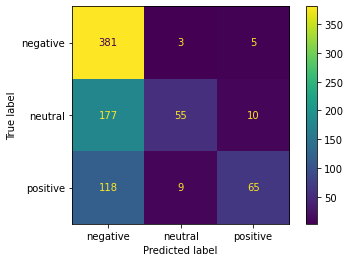

In [124]:
svcs_score = accuracy_score(ys_test, svcs_preds)
print(svcs_score)
svcs_matrix = plot_confusion_matrix(svcs, xs_test, ys_test)
print(svcs_matrix)
svcs_report = classification_report(ys_test, svcs_preds)
print(svcs_report)

# Delta

### Tfidf vectorization & splitting into train test

In [125]:
xd = delta['text']

In [126]:
yd = delta['airline_sentiment']

In [127]:
xd = tf.fit_transform(xd)

In [128]:
xd_train, xd_test, yd_train, yd_test = train_test_split(xd, yd, test_size=0.34, random_state=101)

### ID3 our - 64.94% paper - 42.28%

In [129]:
id3d = RandomForestClassifier(n_estimators=250, criterion='entropy')

In [130]:
id3d.fit(xd_train, yd_train)

RandomForestClassifier(criterion='entropy', n_estimators=250)

In [131]:
id3d_preds = id3d.predict(xd_test)

0.6521164021164021
              precision    recall  f1-score   support

    negative       0.64      0.80      0.71       308
     neutral       0.60      0.58      0.59       261
    positive       0.81      0.51      0.63       187

    accuracy                           0.65       756
   macro avg       0.68      0.63      0.64       756
weighted avg       0.67      0.65      0.65       756



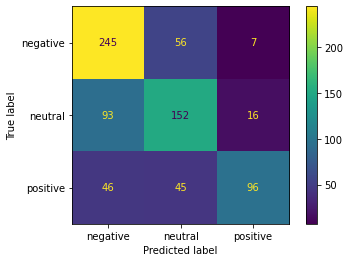

In [132]:
id3d_score = accuracy_score(yd_test, id3d_preds)
print(id3d_score)
id3d_matrix = plot_confusion_matrix(id3d, xd_test, yd_test)
print(id3d_matrix)
id3d_report = classification_report(yd_test, id3d_preds)
print(id3d_report)

### Random Forest Classifier our - 64.68% paper - 42.08%

In [133]:
rfcd = RandomForestClassifier(n_estimators=250, criterion='gini')

In [134]:
rfcd.fit(xd_train, yd_train)

RandomForestClassifier(n_estimators=250)

In [135]:
rfcd_preds = rfcd.predict(xd_test)

0.6507936507936508
              precision    recall  f1-score   support

    negative       0.63      0.80      0.71       308
     neutral       0.60      0.58      0.59       261
    positive       0.81      0.50      0.62       187

    accuracy                           0.65       756
   macro avg       0.68      0.63      0.64       756
weighted avg       0.67      0.65      0.65       756



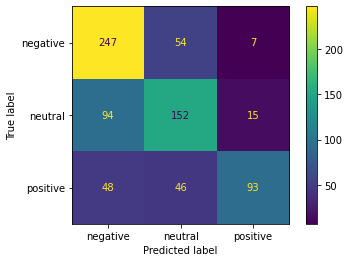

In [136]:
rfcd_score = accuracy_score(yd_test, rfcd_preds)
print(rfcd_score)
rfcd_matrix = plot_confusion_matrix(rfcd, xd_test, yd_test)
print(rfcd_matrix)
rfcd_report = classification_report(yd_test, rfcd_preds)
print(rfcd_report)

### Naive Bayes our - 59.99% paper - 42.28% 

In [137]:
nbd = MultinomialNB()

In [138]:
nbd.fit(xd_train, yd_train)

MultinomialNB()

In [139]:
nbd_preds = nbd.predict(xd_test)

0.5992063492063492
              precision    recall  f1-score   support

    negative       0.54      0.95      0.69       308
     neutral       0.71      0.35      0.47       261
    positive       0.86      0.36      0.51       187

    accuracy                           0.60       756
   macro avg       0.70      0.56      0.56       756
weighted avg       0.68      0.60      0.57       756



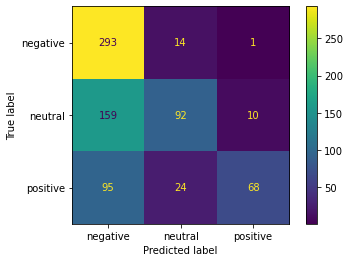

In [140]:
nbd_score = accuracy_score(yd_test, nbd_preds)
print(nbd_score)
nbd_matrix = plot_confusion_matrix(nbd, xd_test, yd_test)
print(nbd_matrix)
nbd_report = classification_report(yd_test, nbd_preds)
print(nbd_report)

### Decision Tree our - 60.31% paper - 42.08%

In [141]:
dtd = DecisionTreeClassifier()

In [142]:
dtd.fit(xd_train, yd_train)

DecisionTreeClassifier()

In [143]:
dtd_preds = dtd.predict(xd_test)

0.6177248677248677
              precision    recall  f1-score   support

    negative       0.65      0.68      0.66       308
     neutral       0.56      0.58      0.57       261
    positive       0.65      0.56      0.60       187

    accuracy                           0.62       756
   macro avg       0.62      0.61      0.61       756
weighted avg       0.62      0.62      0.62       756



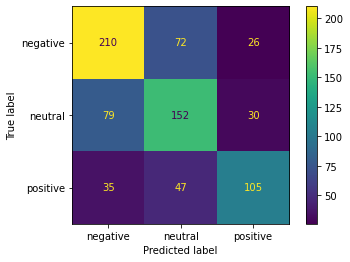

In [144]:
dtd_score = accuracy_score(yd_test, dtd_preds)
print(dtd_score)
dtd_matrix = plot_confusion_matrix(dtd, xd_test, yd_test)
print(dtd_matrix)
dtd_report = classification_report(yd_test, dtd_preds)
print(dtd_report)

### KNN Classifier our - 60.97 % paper - 35.27 %

In [145]:
knnd = KNeighborsClassifier(n_neighbors=5, leaf_size=5, p=2)

In [146]:
knnd.fit(xd_train, yd_train)

KNeighborsClassifier(leaf_size=5)

In [147]:
knnd_preds = knnd.predict(xd_test)

0.6097883597883598
              precision    recall  f1-score   support

    negative       0.62      0.77      0.69       308
     neutral       0.54      0.39      0.46       261
    positive       0.66      0.65      0.65       187

    accuracy                           0.61       756
   macro avg       0.61      0.60      0.60       756
weighted avg       0.60      0.61      0.60       756



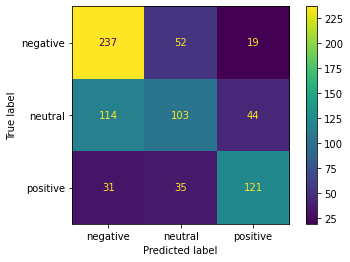

In [148]:
knnd_score = accuracy_score(yd_test, knnd_preds)
print(knnd_score)
knnd_matrix = plot_confusion_matrix(knnd, xd_test, yd_test)
print(knnd_matrix)
knnd_report = classification_report(yd_test, knnd_preds)
print(knnd_report)

### SVC

In [149]:
svcd = SVC(kernel ='poly',degree=2,gamma = 'scale', shrinking = True)

In [150]:
svcd.fit(xd_train, yd_train)

SVC(degree=2, kernel='poly')

In [151]:
svcd_preds = svcd.predict(xd_test)

0.5859788359788359
              precision    recall  f1-score   support

    negative       0.52      0.96      0.68       308
     neutral       0.73      0.34      0.46       261
    positive       0.87      0.32      0.46       187

    accuracy                           0.59       756
   macro avg       0.71      0.54      0.53       756
weighted avg       0.68      0.59      0.55       756



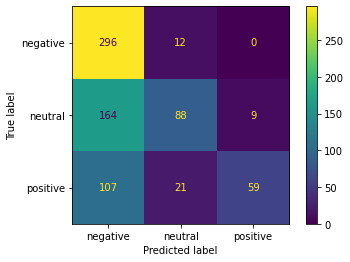

In [152]:
svcd_score = accuracy_score(yd_test, svcd_preds)
print(svcd_score)
svcd_matrix = plot_confusion_matrix(svcd, xd_test, yd_test)
print(svcd_matrix)
svcd_report = classification_report(yd_test, svcd_preds)
print(svcd_report)

# US Airways

### Tfidf vectorization & splitting into train test

In [153]:
xua = us_airways['text']

In [154]:
yua = us_airways['airline_sentiment']

In [155]:
xua = tf.fit_transform(xua)

In [156]:
xua_train, xua_test, yua_train, yua_test = train_test_split(xua, yua, test_size=0.34, random_state=101)

### ID3 our - 80.12% paper - 82.72%

In [157]:
id3ua = RandomForestClassifier(n_estimators=250, criterion='entropy', random_state=42)

In [158]:
id3ua.fit(xua_train, yua_train)

RandomForestClassifier(criterion='entropy', n_estimators=250, random_state=42)

In [159]:
id3ua_preds = id3ua.predict(xua_test)

0.8012108980827447
              precision    recall  f1-score   support

    negative       0.80      1.00      0.89       768
     neutral       0.50      0.02      0.04       128
    positive       0.76      0.27      0.40        95

    accuracy                           0.80       991
   macro avg       0.69      0.43      0.45       991
weighted avg       0.76      0.80      0.73       991



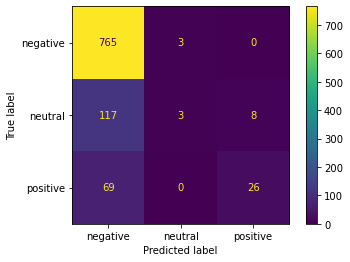

In [160]:
id3ua_score = accuracy_score(yua_test, id3ua_preds)
print(id3ua_score)
id3ua_matrix = plot_confusion_matrix(id3ua, xua_test, yua_test)
print(id3ua_matrix)
id3ua_report = classification_report(yua_test, id3ua_preds)
print(id3ua_report)

### Random Forest Classifier our - 79.91% paper - 82.72%

In [161]:
rfcua = RandomForestClassifier(n_estimators=250, criterion='entropy')

In [162]:
rfcua.fit(xua_train, yua_train)

RandomForestClassifier(criterion='entropy', n_estimators=250)

In [163]:
rfcua_preds = rfcua.predict(xua_test)

0.7951564076690212
              precision    recall  f1-score   support

    negative       0.80      0.99      0.89       768
     neutral       0.36      0.03      0.06       128
    positive       0.72      0.24      0.36        95

    accuracy                           0.80       991
   macro avg       0.63      0.42      0.44       991
weighted avg       0.74      0.80      0.73       991



<Figure size 4800x3200 with 0 Axes>

<Figure size 4800x3200 with 0 Axes>

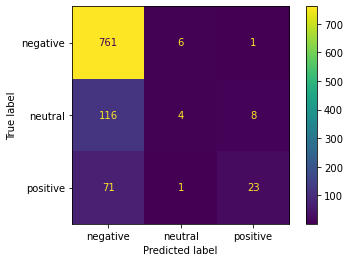

In [214]:
plt.figure(figsize=(12,8),dpi=400)
rfcua_score = accuracy_score(yua_test, rfcua_preds)
print(rfcua_score)

rfcua_report = classification_report(yua_test, rfcua_preds)
print(rfcua_report)

<Figure size 4800x3200 with 0 Axes>

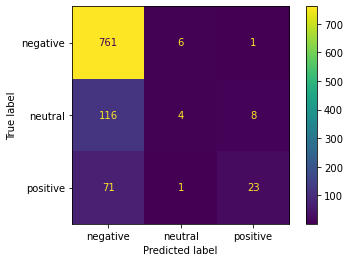

In [215]:
plt.figure(figsize=(12,8),dpi=400)
rfcua_matrix = plot_confusion_matrix(rfcua, xua_test, yua_test)
print(rfcua_matrix)

### Naive Bayes not nice our - 77.49% paper - 82.72%

In [165]:
nbua = MultinomialNB()

In [166]:
nbua.fit(xua_train, yua_train)

MultinomialNB()

In [167]:
nbua_preds = nbua.predict(xua_test)

0.7749747729566094
              precision    recall  f1-score   support

    negative       0.77      1.00      0.87       768
     neutral       0.00      0.00      0.00       128
    positive       0.00      0.00      0.00        95

    accuracy                           0.77       991
   macro avg       0.26      0.33      0.29       991
weighted avg       0.60      0.77      0.68       991



C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


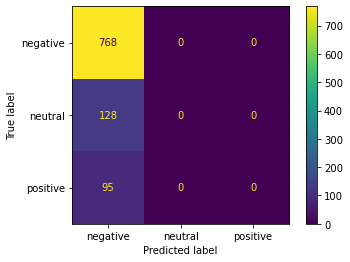

In [168]:
nbua_score = accuracy_score(yua_test, nbua_preds)
print(nbua_score)
nbua_matrix = plot_confusion_matrix(nbua, xua_test, yua_test)
print(nbua_matrix)
nbua_report = classification_report(yua_test, nbua_preds)
print(nbua_report)

### Decision Tree our - 75.27paper - 82.72%

In [169]:
dtua = DecisionTreeClassifier()

In [170]:
dtua.fit(xua_train, yua_train)

DecisionTreeClassifier()

In [171]:
dtua_preds = dtua.predict(xua_test)

0.7487386478304743
              precision    recall  f1-score   support

    negative       0.83      0.88      0.86       768
     neutral       0.29      0.25      0.27       128
    positive       0.51      0.35      0.41        95

    accuracy                           0.75       991
   macro avg       0.54      0.49      0.51       991
weighted avg       0.73      0.75      0.74       991



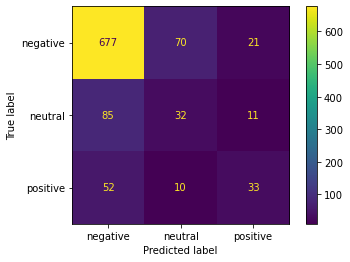

In [172]:
dtua_score = accuracy_score(yua_test, dtua_preds)
print(dtua_score)
dtua_matrix = plot_confusion_matrix(dtua, xua_test, yua_test)
print(dtua_matrix)
dtua_report = classification_report(yua_test, dtua_preds)
print(dtua_report)

### KNN Classifier our - 77.80% paper - 82.72%

In [173]:
knnua = KNeighborsClassifier(n_neighbors=5, leaf_size=5, p=2)

In [174]:
knnua.fit(xua_train, yua_train)

KNeighborsClassifier(leaf_size=5)

In [175]:
knnua_preds = knnua.predict(xua_test)

0.7780020181634713
              precision    recall  f1-score   support

    negative       0.83      0.92      0.87       768
     neutral       0.35      0.21      0.26       128
    positive       0.57      0.41      0.48        95

    accuracy                           0.78       991
   macro avg       0.58      0.51      0.54       991
weighted avg       0.75      0.78      0.76       991



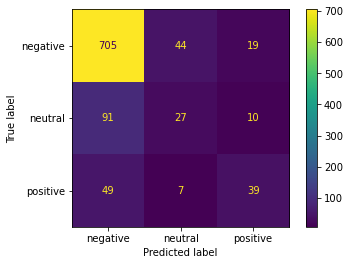

In [176]:
knnua_score = accuracy_score(yua_test, knnua_preds)
print(knnua_score)
knnua_matrix = plot_confusion_matrix(knnua, xua_test, yua_test)
print(knnua_matrix)
knnua_report = classification_report(yua_test, knnua_preds)
print(knnua_report)

### SVC

In [177]:
svcua = SVC(kernel ='poly',degree=2, gamma = 'scale', shrinking = True)

In [178]:
svcua.fit(xua_train, yua_train)

SVC(degree=2, kernel='poly')

In [179]:
svcua_preds = svcua.predict(xua_test)

0.7921291624621595
              precision    recall  f1-score   support

    negative       0.79      1.00      0.88       768
     neutral       0.80      0.03      0.06       128
    positive       0.88      0.15      0.25        95

    accuracy                           0.79       991
   macro avg       0.82      0.39      0.40       991
weighted avg       0.80      0.79      0.72       991



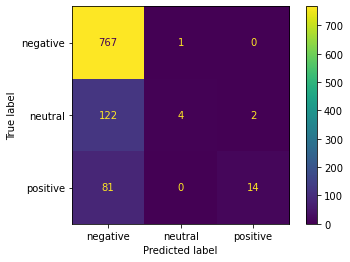

In [180]:
svcua_score = accuracy_score(yua_test, svcua_preds)
print(svcua_score)
svcua_matrix = plot_confusion_matrix(svcua, xua_test, yua_test)
print(svcua_matrix)
svcua_report = classification_report(yua_test, svcua_preds)
print(svcua_report)

# American

### Tfidf vectorization & splitting into train test

In [181]:
xa = american['text']

In [182]:
ya = american['airline_sentiment']

In [183]:
xa = tf.fit_transform(xa)

In [184]:
xa_train, xa_test, ya_train, ya_test = train_test_split(xa, ya, test_size=0.34, random_state=101)


### ID3 our - 63.95%  paper - 72.21%

In [185]:
id3a = RandomForestClassifier(n_estimators=250, criterion='entropy')

In [186]:
id3a.fit(xa_train, ya_train)

RandomForestClassifier(criterion='entropy', n_estimators=250)

In [187]:
id3a_preds = id3a.predict(xa_test)

0.6104651162790697
              precision    recall  f1-score   support

    negative       0.79      0.98      0.87       662
     neutral       0.75      0.24      0.36       164
    positive       0.76      0.44      0.56       113

    accuracy                           0.78       939
   macro avg       0.77      0.55      0.60       939
weighted avg       0.78      0.78      0.75       939



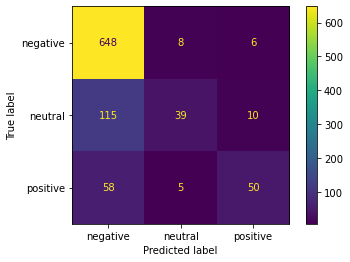

In [188]:
id3a_score = accuracy_score(ya_test, id3a_preds)
print(id3_score)
id3a_matrix = plot_confusion_matrix(id3a, xa_test, ya_test)
print(id3a_matrix)
id3a_report = classification_report(ya_test, id3a_preds)
print(id3a_report)

### Random Forest Classifier our - 77.52% paper - 68.98%

In [189]:
rfca = RandomForestClassifier(n_estimators=250, criterion='gini')

In [190]:
rfca.fit(xa_train, ya_train)

RandomForestClassifier(n_estimators=250)

In [191]:
rfca_preds = rfca.predict(xa_test)

0.77209797657082
              precision    recall  f1-score   support

    negative       0.78      0.97      0.87       662
     neutral       0.69      0.20      0.31       164
    positive       0.75      0.42      0.54       113

    accuracy                           0.77       939
   macro avg       0.74      0.53      0.57       939
weighted avg       0.76      0.77      0.73       939



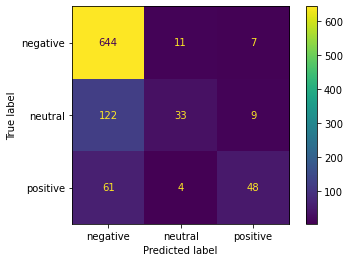

In [192]:
rfca_score = accuracy_score(ya_test, rfca_preds)
print(rfca_score)
rfca_matrix = plot_confusion_matrix(rfca, xa_test, ya_test)
print(rfca_matrix)
rfca_report = classification_report(ya_test, rfca_preds)
print(rfca_report)

### Naive Bayes not nice our - 71.35% paper - 72.21%

In [193]:
nba = MultinomialNB()

In [194]:
nba.fit(xa_train, ya_train)

MultinomialNB()

In [195]:
nba_preds = nba.predict(xa_test)

0.7135250266240681
              precision    recall  f1-score   support

    negative       0.71      1.00      0.83       662
     neutral       1.00      0.02      0.05       164
    positive       1.00      0.04      0.07       113

    accuracy                           0.71       939
   macro avg       0.90      0.35      0.32       939
weighted avg       0.80      0.71      0.60       939



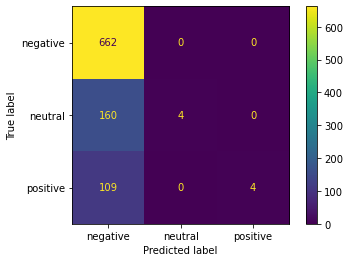

In [196]:
nba_score = accuracy_score(ya_test, nba_preds)
print(nba_score)
nba_matrix = plot_confusion_matrix(nba, xa_test, ya_test)
print(nba_matrix)
nba_report = classification_report(ya_test, nba_preds)
print(nba_report)

### Decision Tree Classifier our - 71.99% paper - 68.98%

In [197]:
dta = DecisionTreeClassifier()

In [198]:
dta.fit(xa_train, ya_train)

DecisionTreeClassifier()

In [199]:
dta_preds = dta.predict(xa_test)

0.7177848775292864
              precision    recall  f1-score   support

    negative       0.80      0.86      0.83       662
     neutral       0.39      0.31      0.35       164
    positive       0.55      0.50      0.52       113

    accuracy                           0.72       939
   macro avg       0.58      0.55      0.57       939
weighted avg       0.70      0.72      0.71       939



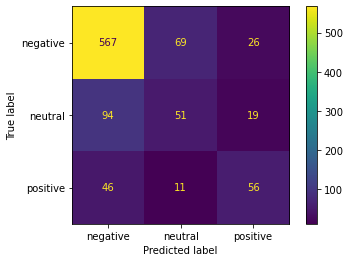

In [200]:
dta_score = accuracy_score(ya_test, dta_preds)
print(dta_score)
dta_matrix = plot_confusion_matrix(dta, xa_test, ya_test)
print(dta_matrix)
dta_report = classification_report(ya_test, dta_preds)
print(dta_report)

### KNN Classifier our - 75.29% paper - 69.43

In [201]:
knna = KNeighborsClassifier(n_neighbors=5, leaf_size=5, p=2)

In [202]:
knna.fit(xa_train, ya_train)

KNeighborsClassifier(leaf_size=5)

In [203]:
knna_preds = knna.predict(xa_test)

0.7529286474973376
              precision    recall  f1-score   support

    negative       0.80      0.91      0.85       662
     neutral       0.44      0.24      0.31       164
    positive       0.71      0.58      0.63       113

    accuracy                           0.75       939
   macro avg       0.65      0.58      0.60       939
weighted avg       0.72      0.75      0.73       939



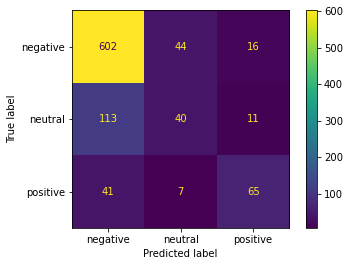

In [204]:
knna_score = accuracy_score(ya_test, knna_preds)
print(knna_score)
knna_matrix = plot_confusion_matrix(knna, xa_test, ya_test)
print(knna_matrix)
knna_report = classification_report(ya_test, knna_preds)
print(knna_report)

### SVC

In [205]:
svca = SVC(kernel ='poly',degree=2, gamma = 'scale', shrinking = True)

In [206]:
svca.fit(xa_train,ya_train)

SVC(degree=2, kernel='poly')

In [207]:
svca_preds = svca.predict(xa_test)

0.7550585729499467
              precision    recall  f1-score   support

    negative       0.75      1.00      0.86       662
     neutral       0.77      0.10      0.18       164
    positive       0.88      0.27      0.41       113

    accuracy                           0.76       939
   macro avg       0.80      0.46      0.48       939
weighted avg       0.77      0.76      0.69       939



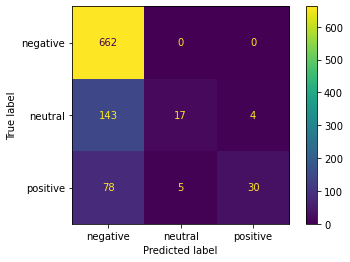

In [208]:
svca_score = accuracy_score(ya_test, svca_preds)
print(svca_score)
svca_matrix = plot_confusion_matrix(svca, xa_test, ya_test)
print(svca_matrix)
svca_report = classification_report(ya_test, svca_preds)
print(svca_report)